In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from numpy.random import uniform, beta

# Spatial discretization (1 unit == 1 meter)
x = np.linspace(0,1,60)

# Probabilistic spatial occupancy considering uncertainty and ignorance

## Defining prior confidence values

Prior confidence is a learned deterministic function which characterizes a model given the environmental context. Examples of quantifiable parameters which affect performance are
- Luminosity (bright or dark condition)
- Air moisture (rain and fog)
- Approximate distance to measurement (capturing the difference between 5 and 50 m)

In this example, we only characterize models by approximate distance, and assume no detrimental weather effects.

Application example: _'Far-away observations'_ (>50m) of a LiDAR model object detection has low reliabilitiy (large ignorance, low information content), while 'nearby observations' (<10m) have high confidence (low ignorance, high information content).

### LiDAR model prior

Prior confidence in LiDAR model @ 0m:  0.990
                                @ 10m: 0.951
                                @ 50m: 0.063



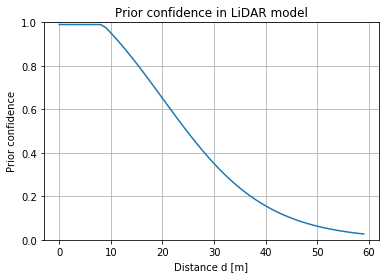

In [2]:
##################
#  LiDAR model
##################
def conf_lidar_func(d, mid, max_val, min_val):
    val = 1 / (1 + np.exp(-0.1*(d - mid)))
    val = 1 - val 
    val = max_val * val
    val += min_val
    if val >= 0.99:
        val = 0.99
    return val

conf_lidar = np.zeros(60)
for i in range(60):
    conf_lidar[i] = conf_lidar_func(i, 20, 1.3, 0.001)

print(f"Prior confidence in LiDAR model @ 0m:  {conf_lidar[0]:.3f}")
print(f"                                @ 10m: {conf_lidar[10]:.3f}")
print(f"                                @ 50m: {conf_lidar[50]:.3f}\n")
    
plt.plot(conf_lidar)
plt.title("Prior confidence in LiDAR model")
plt.xlabel("Distance d [m]")
plt.ylabel("Prior confidence")
plt.grid()
plt.ylim(0,1)
plt.show()

### Camera model prior

Prior confidence in camera model @ 0m:  0.681
                                 @ 10m: 0.652
                                 @ 50m: 0.348



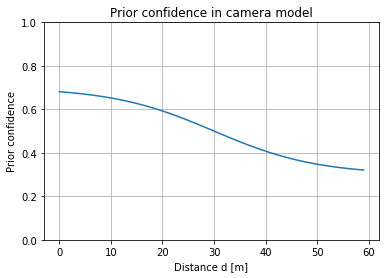

In [3]:
##################
#  Camera model
##################
def conf_camera_func(x, mid, max_val, min_val):
    val = 1 / (1 + np.exp(-0.1*(x - mid)))
    val = 1 - val 
    val = max_val * val
    val += min_val
    return val

conf_camera = np.zeros(60)
for i in range(60):
    conf_camera[i] = conf_camera_func(i, 30, 0.4, 0.3)

print(f"Prior confidence in camera model @ 0m:  {conf_camera[0]:.3f}")
print(f"                                 @ 10m: {conf_camera[10]:.3f}")
print(f"                                 @ 50m: {conf_camera[50]:.3f}\n")

plt.plot(conf_camera)
plt.title("Prior confidence in camera model")
plt.xlabel("Distance d [m]")
plt.ylabel("Prior confidence")
plt.grid()
plt.ylim(0,1)
plt.show()

## Case 1: Adversarial pedestrial road painting 'far away' @ 50m

The camera detection module is known to have useful reliability at long-range detections (confidence 0.348 @ 50m). The model estimates 85% occupancy existence probability in the viscinity of the pedestrian road painting. Elsewhere the existence probability is 1%, meaning there are no detections.

The LiDAR detection module is known to be poor reliability at long-range detections (confidence 0.063 @ 50m). The model provides 1% occpancy existence probability across the whole space, meaning there are no detections.

### Model observations (evidence)

The observation function represents the spatial occupance as outputted by the corresponding detection model.

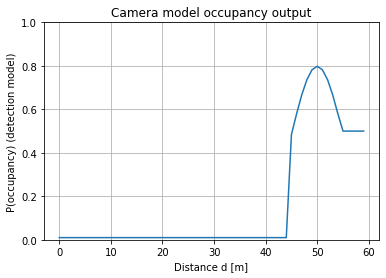

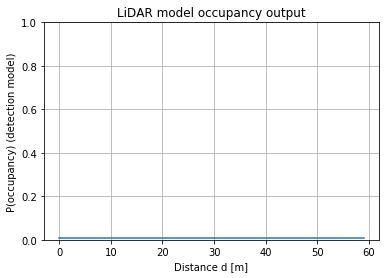

In [4]:
##################
#  Camera model
##################
def p_camera_obs_func(x, mu, sigma, min_val, multiplier):
    if x < mu - sigma:
        val = min_val
    elif x < mu + sigma:
        val = multiplier*norm.pdf(x, mu, sigma)
    else:
        val = 0.5

    return val

p_camera = np.zeros(60)
for i in range(60):
    p_camera[i] = p_camera_obs_func(i, 50, 5, 0.01, 10)

plt.plot(p_camera)
plt.title("Camera model occupancy output")
plt.xlabel("Distance d [m]")
plt.ylabel("P(occupancy) (detection model)")
plt.grid()
plt.ylim(0,1)
plt.show()


##################
#  LiDAR model
##################
def p_lidar_func(x, mu, sigma, min_val, multiplier):
    if x < mu - sigma:
        val = min_val
    elif x < mu + sigma:
        val = multiplier*norm.pdf(x, mu, sigma)
    else:
        val = min_val
    return val

p_lidar = np.zeros(60)
for i in range(60):
    p_lidar[i] = p_lidar_func(i, -5, 5, 0.01, 10)

plt.plot(p_lidar)
plt.title("LiDAR model occupancy output")
plt.xlabel("Distance d [m]")
plt.ylabel("P(occupancy) (detection model)")
plt.grid()
plt.ylim(0,1)
plt.show()

### Integrate observations and priors

The integration is based on representing the observation and prior in terms of probabilistic distributions. In this problem the domain of the random variable Y consists of only two states (Y = 1 : 'occupied' and Y = 0 : 'empty', with 'unknown' or 'no information' represented by the intermediate value Y = 0.5). The two-state observation can be represented as a binomial distribution, and the two-state prior as a beta distribution.

The following computations are performed separately for each spatial location.

#### Binomial distribution for observations

Observations, or model output, are modeled as binomial distributions with the ratio of 'true' observations corresponding to the output probability value $p_{model}$.

$N = 1$

$m = p_{model} \:N = p_{model}$

$l = N - m$

#### Beta distribution for priors

The prior distribution is designed to push the posterior distribution towards $P(Y=1) = 0.5$ ('unknown') in proportion to the specified prior confidence value $C \in (0,1)$. Such a distribution is represented by a beta distribution centered at $\mu_{prior} = 0.5$ with variance parametrized by $C$.

$\sigma^2_{prior} = C \mu_{prior}(1 - \mu_{prior})  = 0.25 C$

The parameters for the corresponding beta distribution are then computed as

$a_{prior} = \left( \frac{1 - \mu_{prior}}{\sigma^2_{prior}} - \frac{1}{\mu_{prior}} \right) \mu_{prior}^2$

$b_{prior} = a \left( \frac{1}{\mu_{prior}} - 1 \right)$

#### Integration of observations and priors

The beta distribution is a conjugate prior to the binomial distribution, meaning the posterior distribution becomes another beta distribution with parameters that can be quickly obtained as an analytical solution.

$a_{post} = m + a_{prior}$

$b_{post} = l + b_{prior}$

The expected value and variance of the posterior distribution is computed as

$\mathbb{E}[\mu_{post}] = \frac{a_{post}}{a_{post} + b_{post}}$

$var[\mu_{post}] = \frac{a_{post} b_{post}}{(a_{post} + b_{post})^2 (a_{post} + b_{post} + 1)}$

In [5]:
def sigma_func(mu, conf):
    '''Computes value for Beta distribution variance corresponding to observation confidence.
    
    NOTE: Inputs cannot be exactly 0 or 1!
    
    Args:
        mu: Probability of proposition between (0, 1)
        conf: Confidence in observation between (0, 1)
    '''
    ratio = 1 - conf
    return ratio*mu*(1.0 - mu)

def a_func(mu, sigma):
    '''Computes parameter 'a' for Beta distribution.
    '''
    return ( (1.0 - mu)/sigma - 1.0/mu )*mu**2

def b_func(mu, a):
    '''Computes parameter 'b' for Beta distribution.
    '''
    return a*(1.0/mu - 1.0)

In [6]:
a_array_camera = np.zeros(60)
b_array_camera = np.zeros(60)
a_array_lidar = np.zeros(60)
b_array_lidar = np.zeros(60)

post_p_array_camera = np.zeros(60)
var_array_camera = np.zeros(80)
post_p_array_lidar = np.zeros(60)
var_array_lidar = np.zeros(80)

for i in range(60):

    ##################
    #  Camera model
    ##################
    mu_1 = p_camera[i]
    conf_1 = conf_camera[i]

    N_1 = 1
    m_1 = N_1 * mu_1
    l_1 = N_1 - m_1

    # Camera prior
    mu_prior_1 = 0.5
    prior_conf_1 = 1.0 - conf_1  # The relative weight of the prior
    sigma_prior_1 = sigma_func(mu_prior_1, prior_conf_1)

    a_prior_1 = a_func(mu_prior_1, sigma_prior_1)
    b_prior_1 = b_func(mu_prior_1, a_prior_1)

    # Camera integration
    a_post_1 = m_1 + a_prior_1
    b_post_1 = l_1 + b_prior_1

    # Store Beta distribution parameters
    a_array_camera[i] = a_post_1
    b_array_camera[i] = b_post_1
    
    post_p_array_camera[i] = a_post_1 / (a_post_1 + b_post_1)
    var_array_camera[i] = a_post_1*b_post_1 / ( (a_post_1 + b_post_1)**2 * (a_post_1 + b_post_1 + 1.0) )
    
    
    #################
    #  LiDAR model
    #################
    mu_2 = p_lidar[i]
    conf_2 = conf_lidar[i]

    N_2 = 1
    m_2 = N_2 * mu_2
    l_2 = N_2 - m_2

    # LiDAR prior
    mu_prior_2 = 0.5
    prior_conf_2 = 1.0 - conf_2  # The relative weight of the prior
    sigma_prior_2 = sigma_func(mu_prior_2, prior_conf_2)

    a_prior_2 = a_func(mu_prior_2, sigma_prior_2)
    b_prior_2 = b_func(mu_prior_2, a_prior_2)

    # LiDAR integration
    a_post_2 = m_2 + a_prior_2
    b_post_2 = l_2 + b_prior_2
    
    # Store Beta distribution parameters
    a_array_lidar[i] = a_post_2
    b_array_lidar[i] = b_post_2
    
    post_p_array_lidar[i] = a_post_2 / (a_post_2 + b_post_2)
    var_array_lidar[i] = a_post_2*b_post_2 / ( (a_post_2 + b_post_2)**2 * (a_post_2 + b_post_2 + 1.0) )


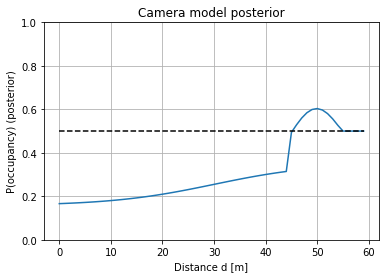

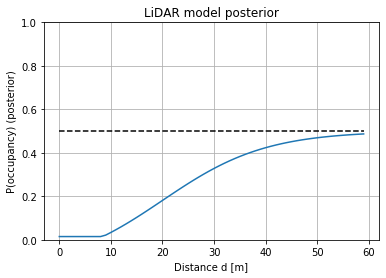

In [7]:
plt.plot(post_p_array_camera)
plt.plot(0.5*np.ones(60), 'k--')
plt.title("Camera model posterior")
plt.xlabel("Distance d [m]")
plt.ylabel("P(occupancy) (posterior)")
plt.grid()
plt.ylim(0,1)
plt.show()

plt.plot(post_p_array_lidar)
plt.plot(0.5*np.ones(60), 'k--')
plt.title("LiDAR model posterior")
plt.xlabel("Distance d [m]")
plt.ylabel("P(occupancy) (posterior)")
plt.grid()
plt.ylim(0,1)
plt.show()

#### Model fusion using probabilistic inference

The posterior distributions of a variable set of models can be probabilistically fused by modeling the perception system as a Naive-Bayes graphical model using approximate inference to find the probability $P(Y=1|X_1, X_2, \theta)$, according to their relative probability and uncertainty magnitude. The fused result can either be represented as a probability distribution, or an expected probability and uncertainty value (expressed as variance).

$P(Y=1 | X_1, X_2, \theta) = \frac{P(X_1|Y=1,\theta) \: P(X_2|Y=1,\theta) \: P(Y=1 | \theta)}{\sum_{y=(0,1)} P(X_1|Y=y) P(Y=y) \: \sum_{y=(0,1)} P(X_2|Y=y) P(Y=y)} $

![naive_bayes](https://user-images.githubusercontent.com/34254153/81291173-44b57380-90a4-11ea-8c6b-dcf78845e2a2.png)

In [8]:
def sample_model(a_1, b_1, a_2, b_2):
    '''
    '''
    a = uniform()
    b = beta(a_1, b_1)
    c = beta(a_2, b_2)

    d = 1.0 - b
    e = 1.0 - c
    a_prime = 1 - a

    prob_y_1 = (a * b * c) / ( d*e*a_prime + a*b*c )
    
    return prob_y_1

In [9]:
fusion_p_array = np.zeros(60)
fusion_var_array = np.zeros(60)

for i in range(60):
    
    a_camera = a_array_camera[i]
    b_camera = b_array_camera[i]
    a_lidar = a_array_lidar[i]
    b_lidar = b_array_lidar[i]
    
    probs = []
    
    for j in range(1000):
        
        prob_y_1 = sample_model(a_camera, b_camera, a_lidar, b_lidar)
        probs.append(prob_y_1)
    
    #print(probs)
    fusion_p_array[i] = np.mean(probs)
    fusion_var_array[i] = np.var(probs)
        

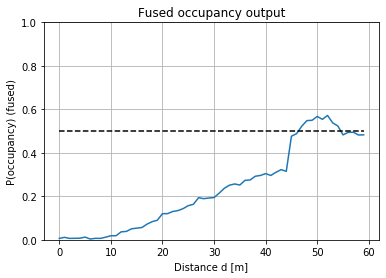

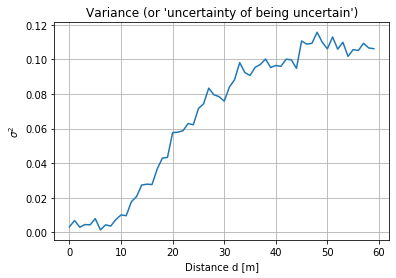

In [10]:
plt.plot(fusion_p_array)
plt.plot(0.5*np.ones(60), 'k--')
plt.title("Fused occupancy output")
plt.xlabel("Distance d [m]")
plt.ylabel("P(occupancy) (fused)")
plt.grid()
plt.ylim(0,1)
plt.show()

plt.plot(fusion_var_array)
plt.title("Variance (or 'uncertainty of being uncertain')")
plt.xlabel("Distance d [m]")
plt.ylabel(r'$\sigma^2$')
plt.grid()
plt.show()